In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score as sil_, calinski_harabasz_score as calinski_
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import re
from datetime import datetime, timezone
from sklearn.preprocessing import OneHotEncoder
import ipaddress
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from collections import Counter
import plotly.express as px
import matplotlib.dates as mdates
import folium
import pytz
from timezonefinder import TimezoneFinder
import pickle


C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Loading and Initial Preprocessing

In this section, we:
- Import required libraries
- Load the dataset
- Convert timestamps
- Check data quality
- remove duplicates and non some nan values

In [2]:
df = pd.read_csv('data/omnipot.csv')

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

In [5]:
# filling payload nan with "" the ndrop nan that are not in the payload column as empty payloads are valid
df.fillna({"payload_4kb_hex":""}, inplace=True)
df.dropna(inplace=True)

In [6]:
def get_ip_encoding(ipv4):
    oct1, oct2, oct3, oct4 = ipv4.split('.')
    return  int(oct1), int(oct2), int(oct3), int(oct4)

df[['src_oct1', 'src_oct2', 'src_oct3', 'src_oct4']] = df["src_ip"].apply(get_ip_encoding).apply(pd.Series)
df[['dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4']] = df["dst_ip"].apply(get_ip_encoding).apply(pd.Series)

In [7]:
df["src_geo_str"] = df["src_geo_str"].str.split("|").apply(lambda lst: [float(x) for x in lst])
df["dst_geo_str"] = df["dst_geo_str"].str.split("|").apply(lambda lst: [float(x) for x in lst])

# 2. Geographic Feature Engineering

Processing geographical data:
- Convert coordinates to cartesian
- Calculate geographic distributions
- Process city and country information

In [8]:
def get_lat_lon(geo_list):
    lon = float(geo_list[0])
    lat = float(geo_list[1])
    lat_sin = np.sin(np.radians(lat))
    lat_cos = np.cos(np.radians(lat))
    lon_sin = np.sin(np.radians(lon))
    lon_cos = np.cos(np.radians(lon))

    return [lat, lon, lat_sin, lat_cos, lon_sin, lon_cos]


In [9]:
df[["src_lat","src_lon","src_lat_sin", "src_lat_cos", "src_lon_sin", "src_lon_cos"]] = df["src_geo_str"].apply(get_lat_lon).apply(pd.Series)
df[["dst_lat","dst_lon","dst_lat_sin", "dst_lat_cos", "dst_lon_sin", "dst_lon_cos"]] = df["dst_geo_str"].apply(get_lat_lon).apply(pd.Series)

df.drop(["src_geo_str", "dst_geo_str"], inplace=True, axis=1)

# 3. Time based attack analysis

In [10]:
tf = TimezoneFinder()

# Step 1: Ensure timestamp is timezone-aware (UTC)
if df["timestamp"].dt.tz is None:
    df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")

# Step 2: Get timezones from lat/lon
def get_timezone(lat, lon):
    try:
        return tf.timezone_at(lat=lat, lng=lon)
    except:
        return None

df["src_timezone"] = df.apply(lambda row: get_timezone(row["src_lat"], row["src_lon"]), axis=1)
df["dst_timezone"] = df.apply(lambda row: get_timezone(row["dst_lat"], row["dst_lon"]), axis=1)

# Step 3: Convert to local time
def convert_to_local(row, tz_col):
    try:
        if pd.notnull(row[tz_col]):
            tz = pytz.timezone(row[tz_col])
            local_time = row["timestamp"].astimezone(tz)
            return local_time
    except:
        return pd.NaT

df["src_local_time"] = df.apply(lambda row: convert_to_local(row, "src_timezone"), axis=1)
df["dst_local_time"] = df.apply(lambda row: convert_to_local(row, "dst_timezone"), axis=1)

# Extract hour safely from timezone-aware timestamps
df["dst_local_hour"] = df["dst_local_time"].apply(lambda x: x.hour if pd.notnull(x) else np.nan)
df["src_local_hour"] = df["src_local_time"].apply(lambda x: x.hour if pd.notnull(x) else np.nan)

In [11]:
avg_morning_src_by_country = df[df["src_local_hour"] <= 12].groupby("src_country")["src_local_hour"].mean().sort_values()
avg_morning_dst_by_country = df[df["dst_local_hour"] <= 12].groupby("dst_country")["dst_local_hour"].mean().sort_values()

avg_aft_src_by_country = df[df["src_local_hour"] >= 12].groupby("src_country")["src_local_hour"].mean().sort_values()
avg_aft_dst_by_country = df[df["dst_local_hour"] >= 12].groupby("dst_country")["dst_local_hour"].mean().sort_values()

## 3.1 Temporal Feature engeneering

In [12]:
# Time-based features using timezone-aware timestamps
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['timestamp'].dt.dayofweek.isin([5,6]).astype(int)

In [13]:
def has_sequential_ports(ports):
    ports_sorted = np.sort(ports)
    return int(np.any(np.diff(ports_sorted) == 1))

port_patterns = df.groupby('src_ip').agg(
    sequential_ports = ('dst_port', has_sequential_ports),
    port_range = ('dst_port', lambda x: x.max() - x.min())
    ).reset_index()

df = df.merge(port_patterns, on='src_ip', how='left')

# Protocol-Level Analysis and Attack Patterns

This section analyzes protocol-specific patterns in attacks to identify:
- Protocol-specific vulnerabilities
- Common attack vectors
- Service targeting patterns

In [14]:
cic_protocols = ["HTTP", "HTTPS", "DNS", "TELNET", "SMTP", "SSH", "IRC", "TCP", "UDP", "DHCP", "ARP", "ICMP", "IPv", "LLC"]
cic_protocols_upper = [p.upper() for p in cic_protocols]

df["protocol_standardized"] = df["protocol"].str.upper().where(
    df["protocol"].str.upper().isin(cic_protocols_upper), "OTHER"
)

In [15]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
protocol_encoded = encoder.fit_transform(df[['protocol_standardized']])
encoded_columns = [col.replace("protocol_standardized_", "") for col in encoder.get_feature_names_out(['protocol_standardized'])]
df = df.join(pd.DataFrame(protocol_encoded, columns=encoded_columns, index=df.index))
df.drop(columns=["protocol_standardized"], inplace=True, errors="ignore")
df

,src_port,dst_port,timestamp,src_as,src_city,src_country,src_countryCode,src_ip,src_proxy,src_regionName,...,day_of_week,is_weekend,sequential_ports,port_range,HTTP,HTTPS,OTHER,SMTP,SSH,TELNET
0,64787,445,2025-02-05 09:01:59.923000+00:00,AS8452 TE-AS,Alexandria,Egypt,EG,102.43.79.235,False,Alexandria,...,2,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
1,59105,23,2025-03-01 00:00:52.674000+00:00,AS4788 TM TECHNOLOGY SERVICES SDN. BHD.,Puchong Batu Dua Belas,Malaysia,MY,175.143.203.217,False,Selangor,...,5,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,13652,22,2025-04-06 07:32:11.683000+00:00,AS6939 Hurricane Electric LLC,Alameda,United States,US,184.105.247.252,False,California,...,6,1,1,29984,0.0,0.0,0.0,0.0,1.0,0.0
3,64010,445,2025-02-05 09:01:56.417000+00:00,AS8452 TE-AS,Alexandria,Egypt,EG,102.43.79.235,False,Alexandria,...,2,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
4,60497,22,2025-04-06 07:32:16.244000+00:00,AS6939 Hurricane Electric LLC,Fremont,United States,US,64.62.197.112,False,California,...,6,1,0,29983,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675078,20720,23,2025-03-31 23:59:03.007000+00:00,AS4837 CHINA UNICOM China169 Backbone,Zhengzhou,China,CN,222.138.169.59,False,Henan,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
675079,20769,23,2025-03-31 23:59:16.029000+00:00,AS4837 CHINA UNICOM China169 Backbone,Zhengzhou,China,CN,222.138.169.59,False,Henan,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
675080,20811,23,2025-03-31 23:59:30.052000+00:00,AS4837 CHINA UNICOM China169 Backbone,Zhengzhou,China,CN,222.138.169.59,False,Henan,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
675081,54818,23,2025-03-31 23:59:33.627000+00:00,AS140810 Megacore Technology Company Limited,Hanoi,Vietnam,VN,103.77.246.172,False,Hanoi,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
df

,src_port,dst_port,timestamp,src_as,src_city,src_country,src_countryCode,src_ip,src_proxy,src_regionName,...,day_of_week,is_weekend,sequential_ports,port_range,HTTP,HTTPS,OTHER,SMTP,SSH,TELNET
0,64787,445,2025-02-05 09:01:59.923000+00:00,AS8452 TE-AS,Alexandria,Egypt,EG,102.43.79.235,False,Alexandria,...,2,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
1,59105,23,2025-03-01 00:00:52.674000+00:00,AS4788 TM TECHNOLOGY SERVICES SDN. BHD.,Puchong Batu Dua Belas,Malaysia,MY,175.143.203.217,False,Selangor,...,5,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,13652,22,2025-04-06 07:32:11.683000+00:00,AS6939 Hurricane Electric LLC,Alameda,United States,US,184.105.247.252,False,California,...,6,1,1,29984,0.0,0.0,0.0,0.0,1.0,0.0
3,64010,445,2025-02-05 09:01:56.417000+00:00,AS8452 TE-AS,Alexandria,Egypt,EG,102.43.79.235,False,Alexandria,...,2,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
4,60497,22,2025-04-06 07:32:16.244000+00:00,AS6939 Hurricane Electric LLC,Fremont,United States,US,64.62.197.112,False,California,...,6,1,0,29983,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675078,20720,23,2025-03-31 23:59:03.007000+00:00,AS4837 CHINA UNICOM China169 Backbone,Zhengzhou,China,CN,222.138.169.59,False,Henan,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
675079,20769,23,2025-03-31 23:59:16.029000+00:00,AS4837 CHINA UNICOM China169 Backbone,Zhengzhou,China,CN,222.138.169.59,False,Henan,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
675080,20811,23,2025-03-31 23:59:30.052000+00:00,AS4837 CHINA UNICOM China169 Backbone,Zhengzhou,China,CN,222.138.169.59,False,Henan,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
675081,54818,23,2025-03-31 23:59:33.627000+00:00,AS140810 Megacore Technology Company Limited,Hanoi,Vietnam,VN,103.77.246.172,False,Hanoi,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
from scipy.stats import entropy

def get_payload_features(payload):
    default = {'length': 0, 'unique_bytes': 0, 'entropy': 0.0,
               'mean_byte': 0.0, 'std_byte': 0.0}
    if not isinstance(payload, str) or len(payload) == 0:
        return default
    try:
        data = bytes.fromhex(payload)
    except ValueError:
        return default
    length = len(data)
    if length == 0:
        return default
    arr = np.frombuffer(data, dtype=np.uint8)
    counts = np.bincount(arr, minlength=256)
    probs = counts / length

    probs = probs[probs > 0]
    ent = entropy(probs, base=2)
    mean = float(arr.mean())
    std = float(arr.std())
    return {
        'length': length,
        'unique_bytes': int(np.count_nonzero(counts)),
        'entropy': float(ent),
        'mean_byte': mean,
        'std_byte': std
    }

payload_feats = ['pl_length', 'pl_unique_bytes', 'pl_entropy', 'pl_mean_byte', 'pl_std_byte']
df[payload_feats] = df["payload_4kb_hex"].apply(get_payload_features).apply(pd.Series)

In [18]:
def decode_payload(hex_str: str, protocol: str) -> str:
    if not hex_str or not isinstance(hex_str, str):
        return ""
    
    try:
        raw_bytes = bytes.fromhex(hex_str)
        if not raw_bytes:
            return ""

        # SSH 
        if protocol == 'ssh':
            # Clean SSH banners
            if raw_bytes.startswith(b'SSH-'):
                banner = raw_bytes.decode('utf-8', errors='ignore').split('\n')[0]
                return banner.strip()
            
            # Detect HTTP requests on SSH port
            if raw_bytes.startswith((b'GET ', b'POST ', b'HEAD ', b'PUT ')):
                try:
                    return "HTTP_OVER_SSH: " + raw_bytes.decode('utf-8').split('\r\n')[0]
                except:
                    return "HTTP_OVER_SSH_BINARY"
            
            # Detect binary commands
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if any(cmd in text.lower() for cmd in ['wget', 'curl', 'chmod', 'sh -c']):
                    return "SSH_CMD: " + ' '.join(text.split())[:200]
            except:
                pass
            
            return f"SSH_BINARY_{len(raw_bytes)}B"

        # HTTP/HTTPS
        elif protocol in ['http', 'https']:
            # Reject SSH banners in HTTP
            if raw_bytes.startswith(b'SSH-'):
                return "SSH_OVER_HTTP"
            
            # Handle valid HTTP
            if raw_bytes.startswith((b'GET ', b'POST ', b'HEAD ', b'PUT ')):
                try:
                    first_line = raw_bytes.decode('utf-8').split('\r\n')[0]
                    return f"HTTP: {first_line}"
                except:
                    return "HTTP_BINARY"
            
            # Handle SSL/TLS
            if len(raw_bytes) > 0 and raw_bytes[0] == 0x16:
                return "SSL_HANDSHAKE"
            
            # Other cases
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if text.strip():
                    return f"HTTP_TEXT: {text[:200]}"
            except:
                pass
            
            return f"HTTP_BINARY_{len(raw_bytes)}B"

        # SMB 
        elif protocol == 'smb':
            if len(raw_bytes) > 8:
                # SMB command mapping
                smb_commands = {
                    0x00: "SMB_NEGOTIATE",
                    0x73: "SMB_NEGOTIATE",  # Common variant
                    0x75: "SMB_TREE_CONNECT",
                    0x1d: "SMB_SESSION_SETUP",
                    0x25: "SMB_CREATE",
                    0x2e: "SMB_IOCTL",
                    0x32: "SMB_READ",
                    0x0b: "SMB_TREE_DISCONNECT"
                }
                cmd = smb_commands.get(raw_bytes[4], f"SMB_UNKNOWN_{raw_bytes[4]}")
                return cmd if cmd != "SMB_NEGOTIATE" or raw_bytes[4:8] == b'\xffSMB' else "SMB_INVALID"
            return "SMB_EMPTY"

        # Other Protocols 
        else:
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if text.strip():
                    return f"{protocol}_TEXT: {text[:200]}"
            except:
                pass
            return f"{protocol}_BINARY_{len(raw_bytes)}B"

    except Exception as e:
        return f"DECODE_ERROR_{str(e)}"

# Reapply decoding
df['payload_decoded'] = df.apply(
    lambda row: decode_payload(row['payload_4kb_hex'], row['protocol']), 
    axis=1
)

In [19]:
print("=== SSH Payloads ===")
print(df[df['protocol'] == 'ssh']['payload_decoded'].head(5).to_string())

print("\n=== HTTP Payloads ===")
print(df[df['protocol'] == 'http']['payload_decoded'].head(5).to_string())

print("\n=== SMB Payloads ===")
print(df[df['protocol'] == 'smb']['payload_decoded'].head(5).to_string())

=== SSH Payloads ===
2     HTTP_OVER_SSH: GET / HTTP/1.1
4     HTTP_OVER_SSH: GET / HTTP/1.1
21                                 
36                                 
78                       SSH-2.0-Go

=== HTTP Payloads ===
7                 SSL_HANDSHAKE
10    HTTP: GET /hello HTTP/1.1
19    HTTP: GET /hello HTTP/1.1
22                SSL_HANDSHAKE
24         HTTP: GET / HTTP/1.1

=== SMB Payloads ===
0     SMB_UNKNOWN_191
3     SMB_UNKNOWN_239
5                    
11                   
12    SMB_UNKNOWN_191


In [20]:
commands = [
    'wget', 'curl', 'chmod', 'dd', 'http_over_ssh', 'scp', 'passwd', 'ftp', 'nc', 'tar', 'rm -rf',
    'cp', 'mv', 'mkdir', 'touch', 'find', 'ls', 'cat', 'head', 'tail', 'rsync', 'sftp', 'tftp',
    'nmap', 'netstat', 'ss', 'lsof', 'ip', 'ifconfig', 'whoami', 'id', 'uname', 'hostname',
    'dig', 'nslookup', 'traceroute', 'ping', 'sudo', 'su', 'chown', 'setfacl', 'useradd', 'groupadd',
    'bash', 'python', 'perl', 'php', 'ruby', 'socat', 'telnet', 'gcc', 'make', 'systemctl',
    'service', 'journalctl', 'history', 'env', 'crontab', 'echo'
]
for cmd in commands:
    df[f'cmd_{cmd}'] = df['payload_decoded'].str.contains(cmd, case=False).astype(int)

## Analysis of command features added 

In [21]:
df = df.drop(columns=['payload_4kb_hex'])
df.reset_index(drop=True, inplace=True)

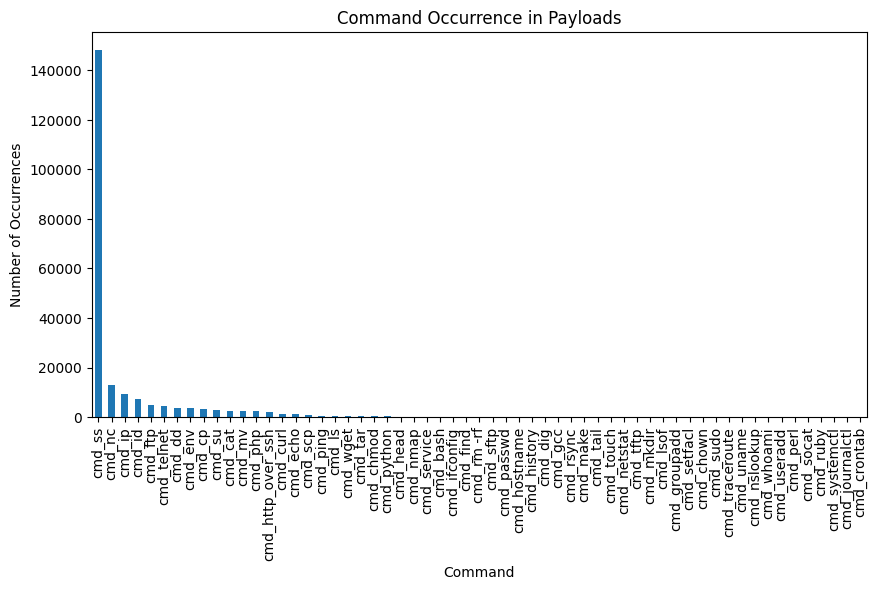

In [22]:
cmd_cols = [col for col in df.columns if col.startswith('cmd_')]
cmd_counts = df[cmd_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
cmd_counts.plot(kind='bar')
plt.title('Command Occurrence in Payloads')
plt.ylabel('Number of Occurrences')
plt.xlabel('Command')
plt.show()

In [23]:
df.replace({True: 1, False: 0}, inplace=True)

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_9112\3673826116.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


encode the AS based on the number of rows it is used in

In [24]:
num_unique_as = df['src_as'].nunique()
as_freq = df['src_as'].value_counts().to_dict()
df['src_as_encoded'] = df['src_as'].map(as_freq)
num_unique_as  

6525

In [25]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')

df['minute'] = df['timestamp'].dt.minute
df["second"] = df['timestamp'].dt.second

In [26]:
df

,src_port,dst_port,timestamp,src_as,src_city,src_country,src_countryCode,src_ip,src_proxy,src_regionName,...,cmd_systemctl,cmd_service,cmd_journalctl,cmd_history,cmd_env,cmd_crontab,cmd_echo,src_as_encoded,minute,second
0,64787,445,2025-02-05 09:01:59.923000+00:00,AS8452 TE-AS,Alexandria,Egypt,EG,102.43.79.235,0,Alexandria,...,0,0,0,0,0,0,0,3943,1,59
1,59105,23,2025-03-01 00:00:52.674000+00:00,AS4788 TM TECHNOLOGY SERVICES SDN. BHD.,Puchong Batu Dua Belas,Malaysia,MY,175.143.203.217,0,Selangor,...,0,0,0,0,0,0,0,726,0,52
2,13652,22,2025-04-06 07:32:11.683000+00:00,AS6939 Hurricane Electric LLC,Alameda,United States,US,184.105.247.252,0,California,...,0,0,0,0,0,0,0,6819,32,11
3,64010,445,2025-02-05 09:01:56.417000+00:00,AS8452 TE-AS,Alexandria,Egypt,EG,102.43.79.235,0,Alexandria,...,0,0,0,0,0,0,0,3943,1,56
4,60497,22,2025-04-06 07:32:16.244000+00:00,AS6939 Hurricane Electric LLC,Fremont,United States,US,64.62.197.112,0,California,...,0,0,0,0,0,0,0,6819,32,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675078,20720,23,2025-03-31 23:59:03.007000+00:00,AS4837 CHINA UNICOM China169 Backbone,Zhengzhou,China,CN,222.138.169.59,0,Henan,...,0,0,0,0,0,0,0,10262,59,3
675079,20769,23,2025-03-31 23:59:16.029000+00:00,AS4837 CHINA UNICOM China169 Backbone,Zhengzhou,China,CN,222.138.169.59,0,Henan,...,0,0,0,0,0,0,0,10262,59,16
675080,20811,23,2025-03-31 23:59:30.052000+00:00,AS4837 CHINA UNICOM China169 Backbone,Zhengzhou,China,CN,222.138.169.59,0,Henan,...,0,0,0,0,0,0,0,10262,59,30
675081,54818,23,2025-03-31 23:59:33.627000+00:00,AS140810 Megacore Technology Company Limited,Hanoi,Vietnam,VN,103.77.246.172,0,Hanoi,...,0,0,0,0,0,0,0,722,59,33


In [27]:
df.drop(columns=["protocol_category", 'src_local_hour', 'dst_local_hour', "timestamp", "src_local_time", "dst_local_time", 'src_ip', 'dst_ip', "src_as", "dst_as", "src_city", "dst_city", "src_country", "dst_country", "src_timezone", "dst_timezone", "src_regionName", "dst_regionName", "src_countryCode", "dst_countryCode", "protocol", "payload_decoded"], inplace=True, errors='ignore')

In [28]:
df

,src_port,dst_port,src_proxy,dst_proxy,src_oct1,src_oct2,src_oct3,src_oct4,dst_oct1,dst_oct2,...,cmd_systemctl,cmd_service,cmd_journalctl,cmd_history,cmd_env,cmd_crontab,cmd_echo,src_as_encoded,minute,second
0,64787,445,0,0,102,43,79,235,45,32,...,0,0,0,0,0,0,0,3943,1,59
1,59105,23,0,0,175,143,203,217,158,247,...,0,0,0,0,0,0,0,726,0,52
2,13652,22,0,1,184,105,247,252,216,238,...,0,0,0,0,0,0,0,6819,32,11
3,64010,445,0,0,102,43,79,235,45,32,...,0,0,0,0,0,0,0,3943,1,56
4,60497,22,0,0,64,62,197,112,104,238,...,0,0,0,0,0,0,0,6819,32,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675078,20720,23,0,0,222,138,169,59,95,179,...,0,0,0,0,0,0,0,10262,59,3
675079,20769,23,0,0,222,138,169,59,95,179,...,0,0,0,0,0,0,0,10262,59,16
675080,20811,23,0,0,222,138,169,59,95,179,...,0,0,0,0,0,0,0,10262,59,30
675081,54818,23,0,0,103,77,246,172,95,179,...,0,0,0,0,0,0,0,722,59,33


In [29]:
TIME_THRESHOLD = 120  # seconds

# ---- 1. IP Construction ----
df["src_ip_str"] = (
    df["src_oct1"].astype(str) + "." +
    df["src_oct2"].astype(str) + "." +
    df["src_oct3"].astype(str) + "." +
    df["src_oct4"].astype(str)
)
df["dst_ip_str"] = (
    df["dst_oct1"].astype(str) + "." +
    df["dst_oct2"].astype(str) + "." +
    df["dst_oct3"].astype(str) + "." +
    df["dst_oct4"].astype(str)
)

# ---- 2. Time Handling ----
df["hour"] = df["hour"].fillna(0).astype(int)
df["minute"] = df["minute"].fillna(0).astype(int)
df["second"] = df["second"].fillna(0).astype(int)
df["time_seconds"] = df["hour"] * 3600 + df["minute"] * 60 + df["second"]

# ---- 3. Burst Assignment ----
def assign_burst_ids(group):
    group = group.sort_values("time_seconds")
    time_diff = group["time_seconds"].diff().fillna(0)
    burst_start = (time_diff > TIME_THRESHOLD).astype(int)
    group["burst_id"] = burst_start.cumsum()
    return group

df = df.groupby(["src_ip_str", "dst_ip_str"], group_keys=False).apply(assign_burst_ids)

group_cols = ["src_ip_str", "dst_ip_str", "burst_id"]

# ---- 4. Burst Packet Arrangement ----
burst_packets = df[group_cols + ["time_seconds", "pl_length"]].copy().sort_values(group_cols + ["time_seconds"])

# ---- 5. Burst Duration ----
burst_duration = burst_packets.groupby(group_cols)["time_seconds"].agg(["min", "max"]).reset_index()
burst_duration.rename(columns={"min": "burst_start_time", "max": "burst_end_time"}, inplace=True)
burst_duration["CIC_FlowDuration"] = burst_duration["burst_end_time"] - burst_duration["burst_start_time"]

# ---- 6. CIC-style Statistics ----
def calculate_burst_stats(group):
    num_packets = group['pl_length'].count()
    total_len = group['pl_length'].sum()
    stats = {
        'pl_length_count': num_packets,
        'pl_length_sum': total_len,
        'pl_length_mean': group['pl_length'].mean(),
        'pl_length_min': group['pl_length'].min(),
        'pl_length_max': group['pl_length'].max(),
    }
    if num_packets > 1:
        stats['pl_length_std'] = group['pl_length'].std(ddof=0)
        stats['pl_length_var'] = group['pl_length'].var(ddof=0)
        stats['CIC_PktLenSkew'] = group['pl_length'].skew()
        stats['CIC_PktLenKurt'] = group['pl_length'].kurt()
        duration = group["time_seconds"].iloc[-1] - group["time_seconds"].iloc[0]
        stats['CIC_PktsPerSec'] = num_packets / duration if duration > 0 else 0
        stats['CIC_BytesPerSec'] = total_len / duration if duration > 0 else 0
        iats = group["time_seconds"].diff().dropna()
        stats['CIC_IAT_Mean'] = iats.mean()
        stats['CIC_IAT_Std'] = iats.std()
        stats['CIC_IAT_Min'] = iats.min()
        stats['CIC_IAT_Max'] = iats.max()
    else:
        stats.update({
            'pl_length_std': 0, 'pl_length_var': 0, 'CIC_PktLenSkew': 0, 'CIC_PktLenKurt': 0,
            'CIC_PktsPerSec': 0, 'CIC_BytesPerSec': 0,
            'CIC_IAT_Mean': 0, 'CIC_IAT_Std': 0, 'CIC_IAT_Min': 0, 'CIC_IAT_Max': 0
        })
    return pd.Series(stats)

burst_stats = burst_packets.groupby(group_cols).apply(calculate_burst_stats).reset_index()

# ---- 7. CIC Column Naming Convention ----
burst_stats.rename(columns={
    'pl_length_count': 'CIC_TotPkts',
    'pl_length_sum': 'CIC_TotLen',
    'pl_length_mean': 'CIC_PktLenMean',
    'pl_length_min': 'CIC_PktLenMin',
    'pl_length_max': 'CIC_PktLenMax',
    'pl_length_std': 'CIC_PktLenStd',
    'pl_length_var': 'CIC_PktLenVar',
}, inplace=True)

# ---- 8. Combine Statistics with Duration ----
burst_features = pd.merge(
    burst_stats,
    burst_duration[group_cols + ['CIC_FlowDuration']],
    on=group_cols,
    how='left'
)

# ---- 9. Add Protocol Encodings ----
if 'encoded_columns' in locals():
    protocol_columns = encoded_columns
else:
    protocol_columns = [col for col in df.columns if col.startswith('proto_')]

df_burst_protocols = df[group_cols + protocol_columns].groupby(group_cols, as_index=False).max()
burst_features = pd.merge(burst_features, df_burst_protocols, on=group_cols, how='left')

# ---- 10. Fill NaNs (from any merge or stat) ----
burst_features.fillna(0, inplace=True)

# ---- 11. Order Columns as in CIC ----
final_col_order = (
    group_cols +
    protocol_columns +
    ['CIC_TotPkts', 'CIC_TotLen', 'CIC_PktLenMean', 'CIC_PktLenMin', 'CIC_PktLenMax', 
     'CIC_PktLenStd', 'CIC_PktLenVar', 'CIC_PktLenSkew', 'CIC_PktLenKurt',
     'CIC_PktsPerSec', 'CIC_BytesPerSec', 'CIC_IAT_Mean', 'CIC_IAT_Std',
     'CIC_IAT_Min', 'CIC_IAT_Max', 'CIC_FlowDuration']
)
burst_features = burst_features[[c for c in final_col_order if c in burst_features.columns]]

# ---- 12. Output ----
print(burst_features.head())

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_9112\1474296527.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["src_ip_str", "dst_ip_str"], group_keys=False).apply(assign_burst_ids)
C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_9112\1474296527.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  burst_stats = burst_packets.groupby(group_cols).apply(calculate_burst_stats).reset_index()

    src_ip_str      dst_ip_str  burst_id  HTTP  HTTPS  OTHER  SMTP  SSH  \
0  1.0.104.204   139.84.199.23         0   0.0    0.0    0.0   0.0  0.0   
1  1.0.104.204     45.77.3.100         0   0.0    0.0    0.0   0.0  0.0   
2  1.0.138.115  139.84.173.144         0   0.0    0.0    1.0   0.0  0.0   
3    1.0.152.1   67.219.106.34         0   0.0    0.0    0.0   0.0  0.0   
4    1.0.155.6   141.164.37.80         0   0.0    0.0    0.0   0.0  0.0   

   TELNET  CIC_TotPkts  ...  CIC_PktLenVar  CIC_PktLenSkew  CIC_PktLenKurt  \
0     1.0          1.0  ...       0.000000        0.000000             0.0   
1     1.0          1.0  ...       0.000000        0.000000             0.0   
2     0.0          3.0  ...    3677.555556       -0.726648             0.0   
3     1.0          1.0  ...       0.000000        0.000000             0.0   
4     1.0          1.0  ...       0.000000        0.000000             0.0   

   CIC_PktsPerSec  CIC_BytesPerSec  CIC_IAT_Mean  CIC_IAT_Std  CIC_IAT_Min  \
0 

In [30]:
burst_features.describe()

,burst_id,HTTP,HTTPS,OTHER,SMTP,SSH,TELNET,CIC_TotPkts,CIC_TotLen,CIC_PktLenMean,...,CIC_PktLenVar,CIC_PktLenSkew,CIC_PktLenKurt,CIC_PktsPerSec,CIC_BytesPerSec,CIC_IAT_Mean,CIC_IAT_Std,CIC_IAT_Min,CIC_IAT_Max,CIC_FlowDuration
count,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000,...,3.775860e+05,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000,377586.000000
mean,3.563342,0.086783,0.097898,0.431928,0.004161,0.182295,0.202741,1.787892,218.542181,109.989215,...,5.006948e+03,-0.046458,0.096039,0.230455,34.784752,2.543474,1.243961,1.649481,3.888481,6.077776
std,16.563655,0.281517,0.297177,0.495345,0.064369,0.386088,0.402041,2.144238,690.245023,257.587161,...,6.551635e+04,0.521212,1.462027,0.814264,222.078620,11.180269,6.082638,9.939842,15.317911,31.536821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,-6.782330,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,36.000000,25.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,239.000000,81.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,488.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,518.000000,175838.000000,6995.500000,...,1.945614e+06,20.705562,458.854307,129.500000,43959.500000,120.000000,84.852814,120.000000,120.000000,1508.000000
